Here I test the new version of processPatch.py, to use the appropriate error in faint points treatment. It used to be that the faint fluxes would be replaced by the faintMean,  but errors stayed the same. In fact we would like to replace errors with faintRMS.

Here I test how the S/N distribution looks like considering individual lightcurves, as well as the distribution of mean S/N per lightcurve considering all lightcurves in a given patch. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.table import Table
from astropy.table import Column
import os
import datetime
import pandas as pd 
import sys
path_to_home = '/Users/chris/GradResearch/'
sys.path.insert(0, path_to_home + 'SDSS_S82_FP_research/packages/')
import faintFunctions as faintF 
import variabilityFunctions as varF


## Read-in  raw lightcurves for one patch 

In [2]:
# USE ASTROPY !!!! 

DirIn = '../raw_data/rawDataFPSplit/'
fname = 'g00_21.csv.gz'
raw_data = Table.read(DirIn+fname, format='csv', include_names =['objectId', 'mjd', 
                                                                 'psfFlux', 'psfFluxErr'])
# http://docs.astropy.org/en/stable/io/ascii/read.html 
# gives parameters to reading tables 

In [6]:
oids = np.unique(raw_data['objectId'].data)
np.where(oids == 216234361610047257)

(array([160300]),)

In [7]:
len(oids)

490369

In [15]:
##########  STEP 1 : single-epoch data ###########  
# 1.1  :  convert Flux from erg/cm2/sec/Hz  to Jansky
#         1 Jy = 1.0E-26 W/m^2/Hz = 1.0E-23 erg/s/cm^2/Hz
# make new columns with data in Jy, to follow good 
# programming practice (otherwise, changes are either
# on a view or a copy and it's not always clear)

raw_data['psfFluxJy'] = raw_data['psfFlux'] * 1E23 
raw_data['psfFluxErrJy'] = raw_data['psfFluxErr'] * 1E23 



In [182]:
# 1.2  : drop all rows which have NaNs in psfFlux .... 
m1  = np.isnan(raw_data['psfFlux'].data)  # true if NaN 
m2 = np.bitwise_not(np.isfinite(raw_data['psfFlux'].data))  # true if not finite... 

# logical or : true if either condition satisfied 
m = m1 | m2  

if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    print('In  file %s there are : \n.... %d NaN  psfFlux rows'%(fname, np.sum(m1)))
    print('.... %d not finite  psfFlux rows'% np.sum(m2))
    print('All such rows are dropped')
    indices = np.arange(len(test))
    rows_to_remove = indices[mask]
    raw_data.remove_rows(remove_indices)

# 1.3 : check psfFluxErr : drop all rows which have NaN, or 0 ,
# to avoid getting error when calculating S/N  = psfFlux / psfFluxErr 

m1  = np.isnan(raw_data['psfFluxErr'].data)  # true if NaN 
m2 =  np.bitwise_not(np.isfinite(raw_data['psfFluxErr'].data))  # true if not finite... 
m3 = raw_data['psfFluxErr'].data == 0 
# logical or : true if either condition satisfied 
m = m1 | m2  | m3

if np.sum(m) > 0 :  # only apply if there is anything to drop ... 
    print('In  file %s there are : \n.... %d NaN  psfFluxErr rows'%(fname, np.sum(m1)))
    print('.... %d not finite  psfFluxErr rows'% np.sum(m2))
    print('.... %d psfFluxErr = 0  rows'% np.sum(m3))
    print('All such rows are dropped')

# 1.4 : select points that have S/N  < 2 , flag as Faint...
# initialize a new column with all values set to False :
#flagFaint = Column(data = np.zeros(len(raw_data), dtype=bool), name = 'flagFaint')
# this would also work, but doesn't allow to select good data type 
# raw_data['flagFaint'] = True : makes a new col with int64

# instead of two-steps, make just one : 
mask_SN = (raw_data['psfFluxJy'].data / raw_data['psfFluxErrJy'].data) < 2 
raw_data['flagFaint'] = mask_SN
print('There are %d points of %d that have S/N < 2' %(np.sum(mask_SN),len(mask_SN)))





In [175]:
print('hello')

### Aside : Plot the SN demographics using raw photometry 

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 20

We will save this figure in  /Users/chris/GradResearch/SDSS_S82_FP_research/data_products/Fig_SN_raw_data/2017-05-09/
Saved as SN_demographics.png


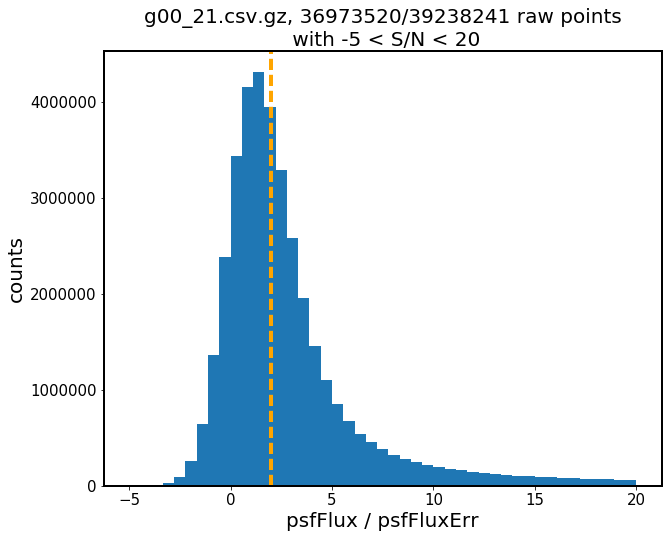

In [111]:
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_SN_raw_data',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)


%matplotlib inline
min_SN, max_SN = -5, 20 
m = (min_SN < SN) *  ( SN < max_SN)

fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.hist(SN[m], bins=45)
ax.set_xlabel('psfFlux / psfFluxErr')
ax.set_ylabel('counts')
ax.set_title(fname+', '+ str(len(SN[m]))+'/'+str(len(SN))+\
             ' raw points\n with '+ str(min_SN)+' < S/N < '+str(max_SN))

ax.axvline(2, ls = '--', color='orange', lw=4)

figname = 'SN_demographics.png'
plt.savefig(outDir + '/' +figname)
print('Saved as %s'%figname)


### Back to analysis : faint points treatment ... 

In [183]:



# 1.5  calculate faint quantities for all rows  where S/N < 2 

# make new columns ...
for faintColname in ['faintMean', 'faintMedian','faintTwoSigma','faintRMS']:
    raw_data[faintColname] = np.nan
    
# temporary assignment 
flux, flux_err = raw_data['psfFluxJy'][mask_SN].data, raw_data['psfFluxErrJy'][mask_SN].data

raw_data['faintMean'][mask_SN]= faintF.calculate_mean(flux, flux_err)
raw_data['faintMedian'][mask_SN] = faintF.calculate_median(flux, flux_err)
raw_data['faintTwoSigma'][mask_SN] = faintF.calculate_2sigma(flux, flux_err)
raw_data['faintRMS'][mask_SN] = faintF.calculate_rms(flux, flux_err)


/Users/chris/GradResearch/SDSS_S82_FP_research/packages/faintFunctions.py:12: RuntimeWarning: divide by zero encountered in true_divide
  xMean = (1/ (norm.sf(-xObs )*np.sqrt(2*np.pi))) * np.exp(-(xObs**2.0) / 2.0) + xObs
/Users/chris/GradResearch/SDSS_S82_FP_research/packages/faintFunctions.py:12: RuntimeWarning: invalid value encountered in multiply
  xMean = (1/ (norm.sf(-xObs )*np.sqrt(2*np.pi))) * np.exp(-(xObs**2.0) / 2.0) + xObs
/Users/chris/GradResearch/SDSS_S82_FP_research/packages/faintFunctions.py:27: RuntimeWarning: divide by zero encountered in true_divide
  xMean = (1/ (norm.sf(-xObs )*np.sqrt(2*np.pi))) * np.exp(-(xObs**2.0) / 2.0) + xObs
/Users/chris/GradResearch/SDSS_S82_FP_research/packages/faintFunctions.py:27: RuntimeWarning: invalid value encountered in multiply
  xMean = (1/ (norm.sf(-xObs )*np.sqrt(2*np.pi))) * np.exp(-(xObs**2.0) / 2.0) + xObs
/Users/chris/GradResearch/SDSS_S82_FP_research/packages/faintFunctions.py:30: RuntimeWarning: invalid value encountered 

In [184]:
np.sum(np.isnan(raw_data['psfFluxErrJy'][mask_SN] /raw_data['faintRMS'][mask_SN]))

288

### Plot rawError  / faintRMS ...

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


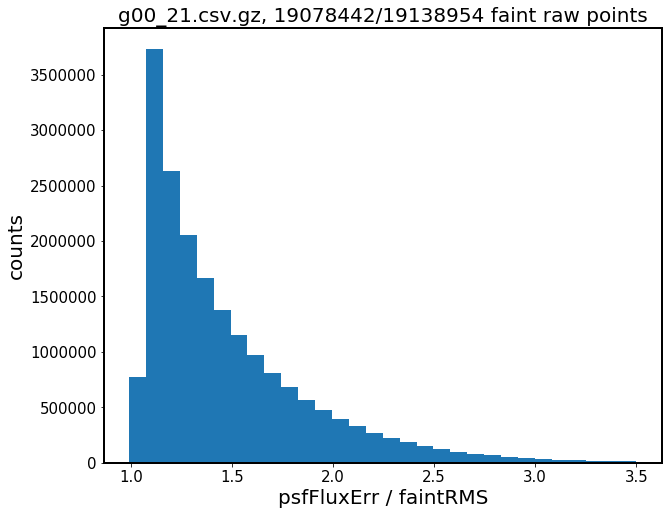

In [219]:
# remove nan rows ... 
flux_err, rms =  raw_data['psfFluxErrJy'][mask_SN].data, raw_data['faintRMS'][mask_SN].data

m1 = np.bitwise_not(np.isnan(rms))
m2 =  (0.99 < flux_err / rms  )*( flux_err / rms < 3.5)
m = m1 * m2 


fig,ax = plt.subplots(1,1,figsize=(10,8))
ax.hist(flux_err[m] / rms[m], bins=30)
ax.set_xlabel('psfFluxErr / faintRMS')
ax.set_ylabel('counts')
ax.set_title(fname+', '+ str(len(rms[m]))+'/'+str(len(rms))+\
             ' faint raw points')

figname = 'FluxErr_RMS_ratio.png'
plt.savefig(outDir + '/' +figname, bbox_inches = 'tight')
print('Saved as %s'%figname)




Conclude: the new error is smaller from the original error up to even 3 times ! 

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:28: RuntimeWarning: divide by zero encountered in log10


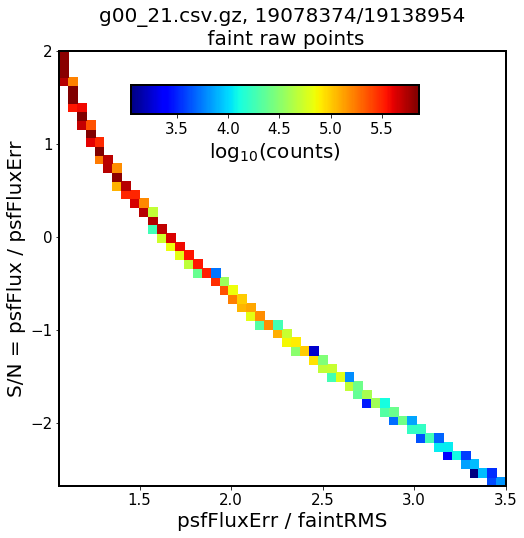

In [224]:
# Plot also     S/N    vs  psfFluxErr / faintRMS : color by counts ....
from matplotlib import ticker
from scipy.stats import binned_statistic_2d

flux_err, rms =  raw_data['psfFluxErrJy'][mask_SN].data, raw_data['faintRMS'][mask_SN].data
SN = raw_data['psfFluxJy'][mask_SN].data / raw_data['psfFluxErrJy'][mask_SN].data 

m1 = np.bitwise_not(np.isnan(rms))
m2 =  (0.99 < (flux_err / rms)  )*( (flux_err / rms) < 3.5)
m3 = SN > -5
m = m1 * m2 *m3

x = flux_err[m] / rms[m]
y = SN[m]

fig,ax = plt.subplots(1,1,figsize=(8,8))
stats = binned_statistic_2d(x=x, y=y, values=x, statistic='count', bins=50)

z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
z_reduce  =  z_sigma
z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
z_rot_flip = np.flipud(z_rot)
z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)

# Plot 2D histogram using pcolor
image = ax.pcolormesh(x_edges,y_edges, np.log10(z_masked), cmap='jet')
cax =   fig.add_axes([0.25, 0.77, 0.5, 0.05]) 
colorbar = fig.colorbar(image,  cax=cax, orientation='horizontal')
colorbar.set_label(r'$\log_{10}(\mathrm{counts})$', fontsize=20)

ax.set_xlabel('psfFluxErr / faintRMS')
ax.set_ylabel('S/N = psfFlux / psfFluxErr')

ax.set_title(fname+', '+ str(len(rms[m]))+'/'+str(len(rms))+\
             '\n faint raw points')
figname = 'FluxErr_RMS_ratio_vs_SN.png'
plt.savefig(outDir + '/' +figname, bbox_inches = 'tight')
print('Saved as %s'%figname)




In [226]:
# 1.6  replace psfFluxJy  by  faintMean ,

# make sure we are only taking values  that are not NaN ... 
mask_NaNs = np.bitwise_not(np.isnan(raw_data['faintRMS'][mask_SN]))

# psfFluxErrJy  by  faintRMS 
raw_data['psfFluxJy'][mask_SN][mask_NaNs] = raw_data['faintMean'][mask_SN][mask_NaNs]
raw_data['psfFluxErrJy'][mask_SN][mask_NaNs] = raw_data['faintRMS'][mask_SN][mask_NaNs]


In [ ]:
%timeit 

In [13]:
#
##########  STEP 2 : Derived Quantities ###########  
#
# Here the main choice is whether we want to introduce 
# selection of which points to use per lightcurve based 
# on S/N before grouping, or after grouping . 
#

# At the moment, it is impossible to apply complicated 
# functions to groupby objects....
# Easier at this point to just convert AstroPy table 
# to Pandas,  and do it from here on in Pandas ...
# Bummer. 

# But thankfully it only takes a few seconds 
# even on mac,  on the full patch  file 
raw_data_df = raw_data[:100].to_pandas()



In [ ]:
raw_data_

In [12]:
import imp
imp.reload(varF)
# 2.2 Calculate stats for LC using only bright points 
mask_bright = ~raw_data_df['flagFaint'].values
bright_grouped = raw_data_df[mask_bright].groupby('objectId')


KeyError: 'flagFaint'

In [11]:
%timeit varMetricsFull_bright  = bright_grouped.apply(varF.computeVarMetrics, flux_column='psfFluxJy', error_column = 'psfFluxErrJy', time_column = 'mjd', calc_sigma_pdf =True)

NameError: name 'bright_grouped' is not defined

In [ ]:
import imp
imp.reload(varF)
# 2.2 Calculate stats for LC using only bright points 
mask_bright = ~raw_data_df['flagFaint'].values
bright_grouped = raw_data_df[mask_bright].groupby('objectId')
varMetricsFull_bright  = bright_grouped.apply(varF.computeVarMetrics, 
                                              flux_column='psfFluxJy',
                                              error_column = 'psfFluxErrJy',
                                              time_column = 'mjd')

# 2.3 Calculate stats for LC using all points 
all_grouped = raw_data_df.groupby('objectId')
varMetricsFull_all  = all_grouped.apply(varF.computeVarMetrics, 
                                              flux_column='psfFluxJy',
                                              error_column = 'psfFluxErrJy',
                                              time_column = 'mjd') 



The two are very different!  Now we want to prepend some string to each column, so that I know which chi2 was calculated using all points, and which using only bright points.Then we want to stack them  : at this point, it's easier to convert all back to AstroPy and use hstack  http://docs.astropy.org/en/stable/api/astropy.table.hstack.html

In [317]:
# 2.4  calculate magnitudes from fluxes ... 
def flux2absigma(flux, fluxsigma):
      """Compute AB mag sigma given flux and flux sigma

      Here units of flux,  fluxsigma  don't matter 
      as long as they are consistent, since we are dividing 
      one by the other, so all the units cancel out.
      """
      FIVE_OVER_2LOG10 = 1.085736204758129569
      return FIVE_OVER_2LOG10 * fluxsigma / flux;


def flux2ab(flux, unit = 'Jy'):
  """Compute AB mag given flux. 

  Accept two unit types :  
  *  'cgs', meaning flux is in  ergs / s / Hz / cm2
  *  'Jy', meaning flux is in Jy.  1 Jy = 1E-23 * ergs/s/Hz/cm2
  """
  if unit == 'Jy':
    return -2.5 * np.log10(flux) + 8.90
  elif unit == 'cgs':
    return -2.5 * np.log10(flux) - 48.6

# Calculate magnitudes based on average fluxes :
# psfMean  psfMedian  psfMeanErr  psfMedianErr 
varMetricsFull_all['psfMean'] = flux2ab(varMetricsFull_all['psfFluxMean'], unit='Jy')
varMetricsFull_all['psfMedian'] = flux2ab(varMetricsFull_all['psfFluxMedian'], unit='Jy')
varMetricsFull_all['psfMeanErr'] = flux2absigma(varMetricsFull_all['psfFluxMean'],
                                                varMetricsFull_all['psfFluxMeanErr'])
varMetricsFull_all['psfMedianErr'] = flux2absigma(varMetricsFull_all['psfFluxMedian'],
                                                  varMetricsFull_all['psfFluxMedianErr'])


varMetricsFull_bright['psfMean'] = flux2ab(varMetricsFull_bright['psfFluxMean'], unit='Jy')
varMetricsFull_bright['psfMedian'] = flux2ab(varMetricsFull_bright['psfFluxMedian'], unit='Jy')
varMetricsFull_bright['psfMeanErr'] = flux2absigma(varMetricsFull_bright['psfFluxMean'],
                                                varMetricsFull_bright['psfFluxMeanErr'])
varMetricsFull_bright['psfMedianErr'] = flux2absigma(varMetricsFull_bright['psfFluxMedian'],
                                                  varMetricsFull_bright['psfFluxMedianErr'])

print('Calculating magnitudes from fluxes is finished')


# 2.5  change colnames to reflect which subset of points per lightcurve was used 
# the easiest way to do it is to add_suffix in pandas 

varMetricsFull_all = varMetricsFull_all.add_suffix('_all')
varMetricsFull_bright = varMetricsFull_bright.add_suffix('_bright')

# 2.6 combine the two ... 
varMetricsFull_combined = pd.concat([varMetricsFull_all,varMetricsFull_bright], axis=1)


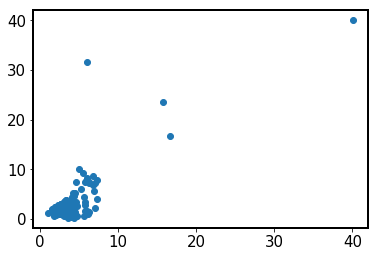

In [323]:
# Now we can easily plot quantities calculated using all points 
# or only bright points,
# as well as select 'bright' objects , which have high meanSN_all,  
# or those that are 'dim' - have a low meanSN_all...  

#plt.hist(varMetricsFull_combined['N_all'])
#plt.hist(varMetricsFull_combined['N_bright'])

plt.scatter(varMetricsFull_combined.chi2DOF_all, varMetricsFull_combined.chi2DOF_bright)

In [325]:
# How many cols we have now per band?

len(varMetricsFull_combined.columns)

56

In [ ]:
# this means over 250 cols in combined file !  
# starts getting overwhelming... 

